# Mastercard or Visa ?
# Image classification with Transfer Learning and Fastai

Author : [Pierre Guillou](https://www.linkedin.com/feed/) - July 16, 2018

Post on Medium : [Mastercard or Visa ? Image classification with Transfer Learning and Fastai]( https://medium.com/@pierre_guillou/mastercard-or-visa-image-classification-with-transfer-learning-and-fastai-5782d011687a)

## Goal

The goal was to **create an application - in 1 hour - that automatically detects whether a credit card is a Mastercard or Visa**.

Let's create a **classifier with 2 outputs : 0 (Mastercard) or 1 (Visa)** !

## 1) Machine Learning with features engineering ?

**How to start ?** The first idea is to ask a credit card specialist what are the distinguishing features of the cards of the 2 networks: the logo (of course), the size of the cards (I do not know), the numbers used (surely), the respective position of texts and figures on the cards (I do not know), the design of the chip (I do not think but ...), the color of the cards (who knows ...), etc.

This method is called **feature engineering**. This means that we will create a number of variables that constitute - in the opinion of a specialist - the list of characteristics to be studied by a Machine Learning model.

This is a possibility but :
1. I am not a bank card specialist 
2. I do not know any bank card specialist 
3. I do not want to do a week-long study on the subject of credit card features

I don't want to create a classifier that asks me to know about credit cards. 

## 2) Deep Learning !

**Deep Learning is the solution !**
I'm going to train a Deep Learning model to classify images of Mastercard and Visa cards. During its training, the model of DL will detect the characteristics and the differences between the images of the 2 types of cards : it will then be able to classify any new image of credit card either in the category Mastercard, or in the category Visa. No need to do feature engineering myself ! The model of DL takes care of it :-)

## 3) Get data

**I need data (images) to train my DL model.** I simply collect images of Mastercard and Visa on Google Images with the script [Google Images Download](https://github.com/hardikvasa/google-images-download) and will train a **Convolutional Neural Network** with an output layer of 2 classes: 0 (Mastercard) or 1 (Visa).

By using this script, I got in 30 minutes (I had to clean manually the sets to delete the non credit card images) : 
- training set (220 images) : 112 Mastercard and 108 Visa images
- validation set (36 images) : 18 Mastercard and 18 Visa images (size : about 16% of the traing set size)
- testing set (9 images) : 5 Mastercard and 4 Visa images

New problem: this type of neural network works very well provided it is trained with large amounts of data. How to deal with my 220 images of cards found on the Internet ?

## 3) Transfer Learning

**Transfer Learning is the solution !** I'm going to use a pretrained ConvNet model to classify images ([resnet34](https://arxiv.org/abs/1512.03385) which won the [ImageNet competition](http://www.image-net.org/challenges/LSVRC/) in 2015), modify its last layer to get only 2 outputs and train it again with my 220 images **to specialize it** in the classification of Mastercard and Visa cards. There you go !

Note : why resnet34 ? Well, I'm just using the idea and the code of the Fastai notebook [lesson1.ipynb](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1.ipynb) about "Image classification with Convolutional Neural Networks of cats and dogs images". I'm using as well the process explained in the blog post [Fun with small image data-sets (Part 2)](https://towardsdatascience.com/fun-with-small-image-data-sets-part-2-54d683ca8c96). This is also Transfer Learning ;-) 

Here is the code. Enjoy :-)

## 4) Results

In only 20s, with a training on 50 epochs (1 epoch = 220 training images) and without using Data Augmentation, **we got an accuracy on the validation set of 88.88%** :-)

Note : as there was no overfitting after 50 epochs, we trained our model on more epochs without changing anything in order to check if the validation accuracy got better. It did not.

Then, we trained our model using Data Augmentation with Learning Rate Restart (10 epochs) and after with Learning Rate Annealing (31 epochs) but our validation accuracy did not improve (83.33%).

Finally, we trained not only our 2 new last layers but the whole model by unfreezing the resnet34 layers on 31 epochs but it did not go over 83.33% of validation accuracy and started overfitting : **220 images to train a model of 130 millions de parameters, it is not enough :-)**

Note : on our testing set (9 images), our model failed only 1 time.

# Importation of the Fastai framework

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
# Check if our GPU works
print(torch.cuda.is_available(),torch.backends.cudnn.enabled)

True True


# Transfer Learning (resnet34)

(Text from Fastai] We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). We'll be studying them in depth later, but for now we'll focus on using them effectively.

In [5]:
PATH = "data/creditcards/"
sz=224; bs=2
arch=resnet34

# First look

In [6]:
os.listdir(PATH)

['models', 'prediction', 'test', 'tmp', 'train', 'valid']

In [7]:
os.listdir(f'{PATH}train')

['mastercard', 'visa']

In [8]:
files = os.listdir(f'{PATH}train/visa')[:10]
files

['1.jpg',
 '10.jpg',
 '100.jpg',
 '101.jpg',
 '102.jpg',
 '103.jpg',
 '104.jpg',
 '105.jpg',
 '106.jpg',
 '107.jpg']

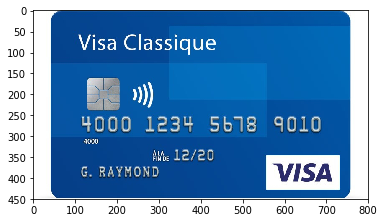

In [9]:
img = plt.imread(f'{PATH}train/visa/{files[6]}')
plt.imshow(img);

## Training data

In [10]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_basic, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, num_workers=1)

In [11]:
print('number of training images :', len(data.trn_ds))
print(f'number of classes : {len(data.classes)}')
print(f'classes : {data.classes}')

number of training images : 220
number of classes : 2
classes : ['mastercard', 'visa']


In [12]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz, col_sz = zip(*size_d.values())
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

number of training images with width < 224 : 5


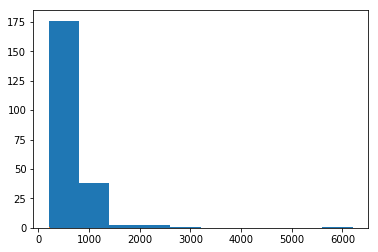

In [13]:
plt.hist(row_sz);
plt.hist(row_sz[row_sz<sz])
h = sz; print(f'number of training images with width < {h} : {len(row_sz[row_sz<h])}')

nucmber of training images with height < 224 : 73


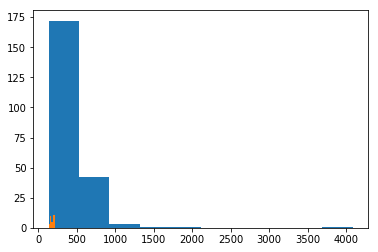

In [14]:
plt.hist(col_sz);
plt.hist(col_sz[col_sz<sz])
h = sz; print(f'nucmber of training images with height < {h} : {len(col_sz[col_sz<h])}')

## Validation data

In [15]:
print('number of validation images :', len(data.val_ds))
print(f'number of classes : {len(data.classes)}')
print(f'classes : {data.classes}')

number of validation images : 36
number of classes : 2
classes : ['mastercard', 'visa']


In [16]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.val_ds.fnames}
row_sz, col_sz = zip(*size_d.values())
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

number of validation images with width < 224 : 0


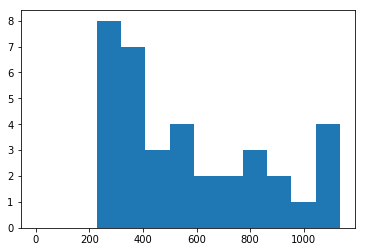

In [17]:
plt.hist(row_sz);
plt.hist(row_sz[row_sz<sz])
h = sz; print(f'number of validation images with width < {h} : {len(row_sz[row_sz<h])}')

nucmber of validation images with height < 224 : 10


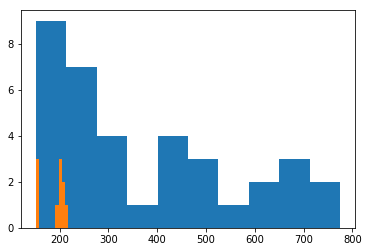

In [18]:
plt.hist(col_sz);
plt.hist(col_sz[col_sz<sz])
h = sz; print(f'nucmber of validation images with height < {h} : {len(col_sz[col_sz<h])}')

# Create a (new) Neural Network model from the pretrained resnet34

In [19]:
# Uncomment the below if you need to reset your precomputed activations
shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [20]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_basic, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, test_name='test')

In [21]:
%time
learn = ConvLearner.pretrained(arch, data, precompute=True)

Wall time: 0 ns
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 50.63it/s]


In [22]:
# Last 2 layers (Fully Connected Layers) that remplace the last layer of the resnet34 model
learn

Sequential(
  (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.25)
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=2, bias=True)
  (7): LogSoftmax()
)

## Choose a Learning Rate

In [23]:
learn.lr_find()

 61%|██████████████████████████████████████████                           | 67/110 [00:00<00:00, 151.09it/s, loss=1.06]


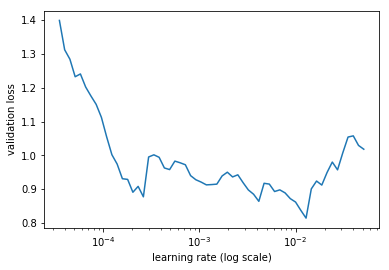

In [24]:
learn.sched.plot()

## Train the 2 last layers of the model (new ones)

In [25]:
lr=1e-4

In [26]:
%%time
learn.fit(lrs=lr, n_cycle=30)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.948612   0.859983   0.361111  
    1      0.940647   0.703264   0.611111                                                                              
    2      0.796516   0.543877   0.722222                                                                              
    3      0.726989   0.503038   0.777778                                                                              
    4      0.707277   0.523711   0.722222                                                                              
    5      0.700482   0.484756   0.777778                                                                              
    6      0.645144   0.531509   0.777778                                                                              
    7      0.698687   0.50295    0.805556                                                                           

[array([0.39491]), 0.8055555555555556]

In [27]:
%%time
learn.fit(lrs=lr, n_cycle=10)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.548607   0.386193   0.861111  
    1      0.578193   0.358609   0.833333                                                                              
    2      0.531898   0.325543   0.861111                                                                              
    3      0.587052   0.387744   0.805556                                                                              
    4      0.62006    0.380796   0.833333                                                                              
    5      0.574802   0.351185   0.888889                                                                              
    6      0.548134   0.374471   0.833333                                                                              
    7      0.578716   0.365825   0.861111                                                                           

[array([0.3455]), 0.8333333333333334]

In [28]:
%%time
learn.fit(lrs=lr, n_cycle=10)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.578401   0.348509   0.805556  
    1      0.656918   0.330968   0.861111                                                                              
    2      0.547816   0.378996   0.805556                                                                              
    3      0.509124   0.385545   0.833333                                                                              
    4      0.584254   0.335741   0.833333                                                                              
    5      0.529676   0.329831   0.833333                                                                              
    6      0.509908   0.371923   0.833333                                                                              
    7      0.518535   0.36892    0.833333                                                                           

[array([0.35866]), 0.8888888888888888]

In only 20s, with a training on 50 epochs (1 epoch = 220 training images) and without using Data Augmentation, **we got an accuracy on the validation set of 88.88%** :-) 

Note : as there was no overfitting after 50 epochs, we trained our model on more epochs without changing anything in order to check if the validation accuracy got better. It did not.

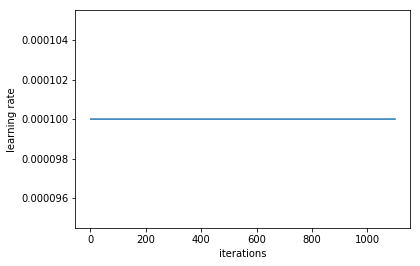

In [29]:
# Visualize the Learning rate used in the training
learn.sched.plot_lr()

In [30]:
# save the model
learn.save('224_last_layers')

# Data augmentation

If you try training for more epochs, you'll notice that we start to *overfit*, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, with a list of functions to apply that randomly change the image however we wish. We can use the pre-defined list of functions `transforms_basic`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

Read: "Data Augmentation using Fastai" https://becominghuman.ai/data-augmentation-using-fastai-aefa88ca03f1

In [33]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_basic, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, num_workers=1)

In [34]:
def get_augs():
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [35]:
ims = np.stack([get_augs() for i in range(6)])

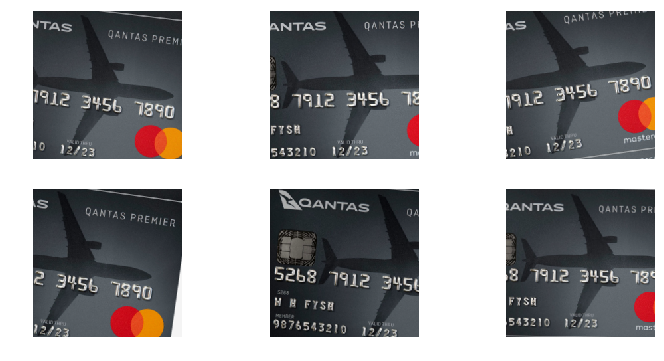

In [36]:
plots(ims, rows=2)

## Train the model using data augmentation

In [37]:
learn.precompute=False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [38]:
learn.lr_find()

 68%|███████████████████████████████████████████████▋                      | 75/110 [00:02<00:01, 32.26it/s, loss=1.46]


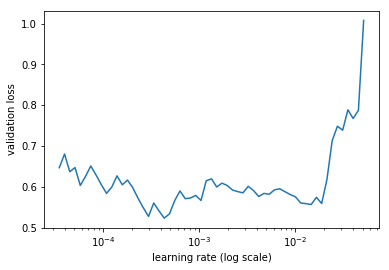

In [39]:
learn.sched.plot()

### Learning Rate Restart

In [53]:
lr=1e-4

In [54]:
learn.precompute=True
learn.load('224_last_layers')
learn.precompute=False

In [55]:
%%time
learn.fit(lrs=lr, n_cycle=10, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.62443    0.361597   0.861111  
    1      0.646995   0.357601   0.888889                                                                              
    2      0.578633   0.374956   0.888889                                                                              
    3      0.662688   0.355084   0.916667                                                                              
    4      0.631838   0.406793   0.833333                                                                              
    5      0.557489   0.361926   0.861111                                                                              
    6      0.565306   0.331816   0.861111                                                                              
    7      0.58424    0.356463   0.888889                                                                           

[array([0.33538]), 0.8888888888888888]

The accuracy did not improved using Data Augmentation on (only) 10 epochs. As well, we did try to train more with different Learning Rates but the accuracy dit not improved. Let's use Learning Rate Annealing.

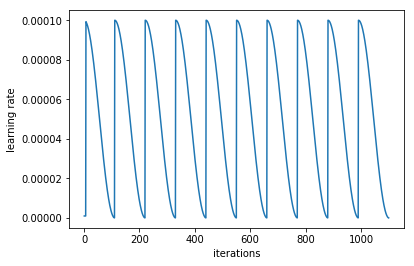

In [56]:
learn.sched.plot_lr()

In [57]:
learn.save('224_data_augmentation_LR_restart')

### Learning Rate Annealing

In [59]:
learn.load('224_data_augmentation_LR_restart')

In [60]:
learn.fit(lrs=lr, n_cycle=5, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.59175    0.36776    0.833333  
    1      0.608886   0.373035   0.861111                                                                              
    2      0.575763   0.382598   0.833333                                                                              
    3      0.555264   0.402008   0.861111                                                                              
    4      0.600644   0.361273   0.861111                                                                              
    5      0.623491   0.370688   0.888889                                                                              
    6      0.636498   0.371833   0.861111                                                                              
    7      0.59601    0.378112   0.833333                                                                           

[array([0.37129]), 0.8611111111111112]

Our validation accuracy did not improve with Learning Rate Annealing (86.11%) with 31 epochs.

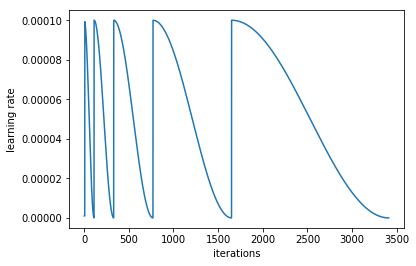

In [61]:
learn.sched.plot_lr()

In [62]:
learn.save('224_data_augmentation_LR_annealing')

## Train the whole model 

In [63]:
# unfreeze the layers of the resnet34 model in order to train them 
learn.unfreeze()

In [64]:
learn.lr_find()

 66%|██████████████████████████████████████████████▍                       | 73/110 [00:04<00:02, 17.24it/s, loss=2.24]


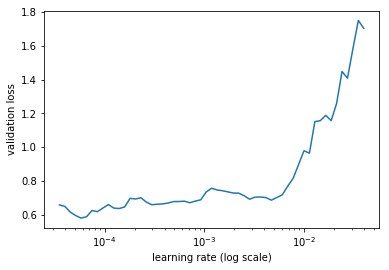

In [65]:
learn.sched.plot()

In [66]:
lr=0.5*1e-4;d=10
lrs=[lr/(d*d),lr/d,lr]

In [67]:
%%time
learn.fit(lrs=lrs, n_cycle=5, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.608108   0.428453   0.861111  
    1      0.705887   0.52314    0.777778                                                                              
    2      0.692833   0.579366   0.722222                                                                              
    3      0.732071   0.620457   0.694444                                                                              
    4      0.713392   0.494097   0.777778                                                                              
    5      0.665892   0.524849   0.722222                                                                              
    6      0.700306   0.541133   0.722222                                                                              
    7      0.681191   0.579805   0.694444                                                                           

[array([0.42604]), 0.8333333333333334]

We trained not only our 2 new last layers but the whole model by unfreezing the resnet34 layers on 31 epochs but it did not go over 83.33% of validation accuracy : **220 images to train a model of 130 millions de parameters, it is not enough :-)**

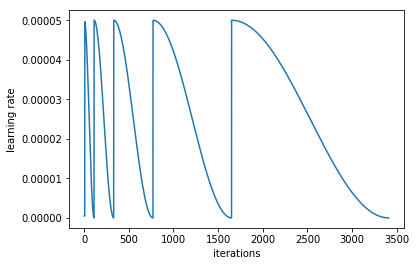

In [68]:
learn.sched.plot_lr()

In [69]:
learn.save('224_all_layers')

## Accuracy on validation set

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [70]:
learn.precompute=True
learn.load('224_last_layers')

In [71]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [72]:
accuracy_np(probs, y)

0.8888888888888888

# Analyzing results on validation set (Confusion Matrix)

In [73]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [74]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[16  2]
 [ 2 16]]


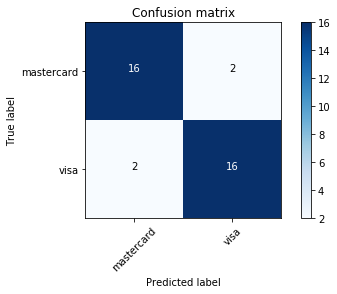

In [75]:
plot_confusion_matrix(cm, data.classes)

# Get the prediction on Test set


In [76]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)
preds = np.argmax(probs, axis=1)

In [77]:
test_files = os.listdir(f'{PATH}test')

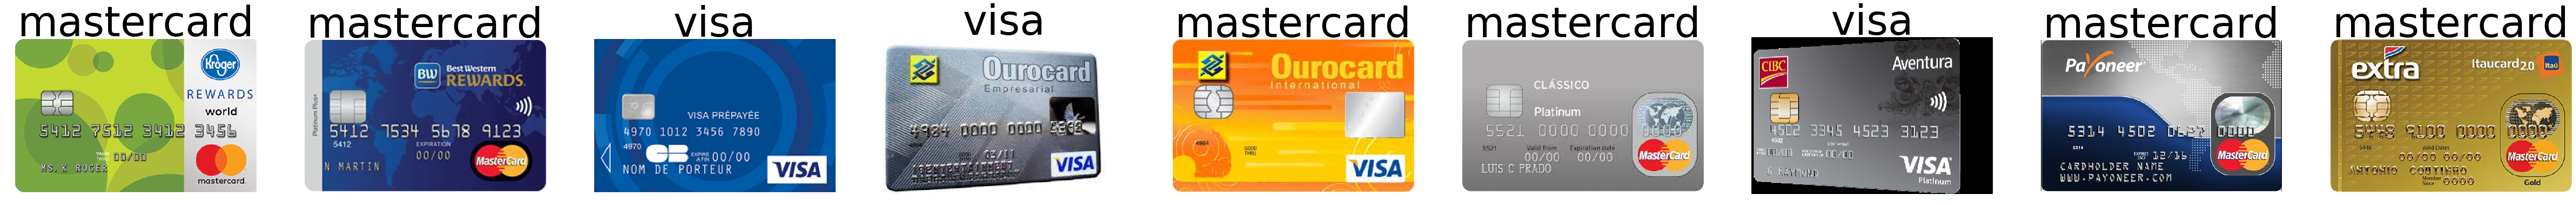

In [78]:
figsize=(100,60)
rows=1
f = plt.figure(figsize=figsize)
for i in range(len(test_files)):
    sp = f.add_subplot(rows, len(test_files)//rows, i+1)
    sp.axis('Off')
    sp.set_title(data.classes[preds[i]], fontsize=90)
    plt.imshow(open_image(f'{PATH}test/{test_files[i]}'))

# Get the prediction on a specific image

In [79]:
PATH_PREDICTION = '../../data/creditcards/prediction/'

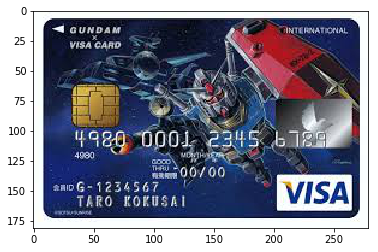

In [84]:
# Get the path to a specific image of the test set (for example : the number 16)
files = os.listdir(f'{PATH_PREDICTION}')
img = open_image(f'{PATH_PREDICTION}{files[1]}')
plt.imshow(img)

In [85]:
# Get the transformation to be applied on the image and then get the prediction
#trn_tfms, val_tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
learn.precompute=False
trn_tfms, val_tfms = tfms_from_model(arch, sz)
im = val_tfms(img)
pred = learn.predict_array(im[None])
result = np.argmax(pred, axis=1)
print(f'The class is : {data.classes[result[0]]}')

The class is : visa


# Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

In [86]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [87]:
# from here we know that 'mastercard' is label 0 and 'visa' is label 1.
data.classes

['mastercard', 'visa']

In [88]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(36, 2)

In [89]:
log_preds[:10]

array([[-0.2019 , -1.69922],
       [-0.26417, -1.46036],
       [-0.19405, -1.73508],
       [-0.85157, -0.55642],
       [-0.18326, -1.7871 ],
       [-0.26642, -1.45293],
       [-0.28009, -1.40941],
       [-0.13179, -2.09168],
       [-0.35813, -1.20059],
       [-1.03979, -0.43622]], dtype=float32)

In [90]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(visa)

In [91]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [92]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [93]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [94]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified (high probabilty should be a Visa)


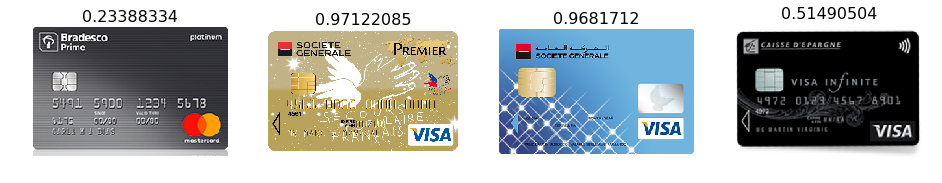

In [95]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified (high probabilty should be a Visa)")

Incorrectly classified (high probabilty should be a Visa)


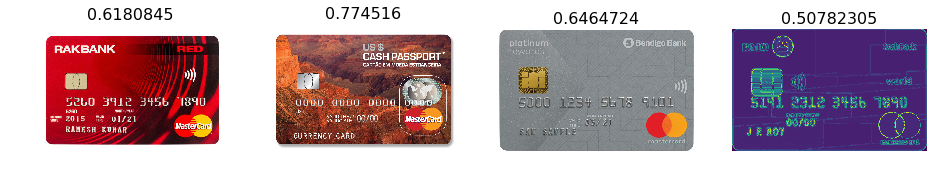

In [96]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified (high probabilty should be a Visa)")

In [97]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct Mastercard


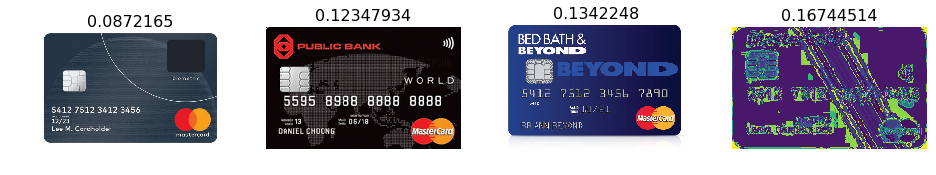

In [98]:
plot_val_with_title(most_by_correct(0, True), "Most correct Mastercard")

Most correct Visa


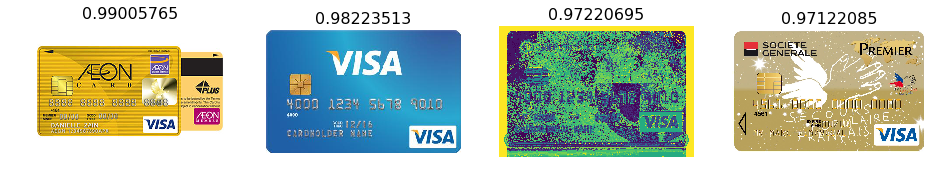

In [99]:
plot_val_with_title(most_by_correct(1, True), "Most correct Visa")

Most incorrect Visa


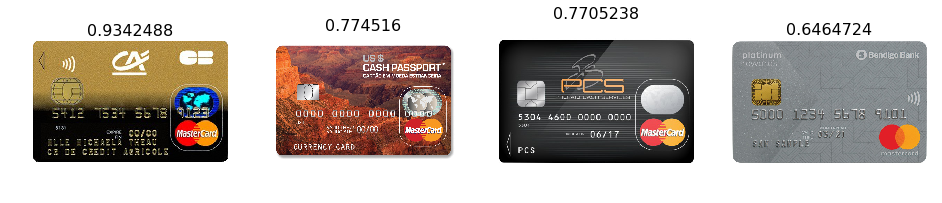

In [100]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect Visa")

Most incorrect Mastercard


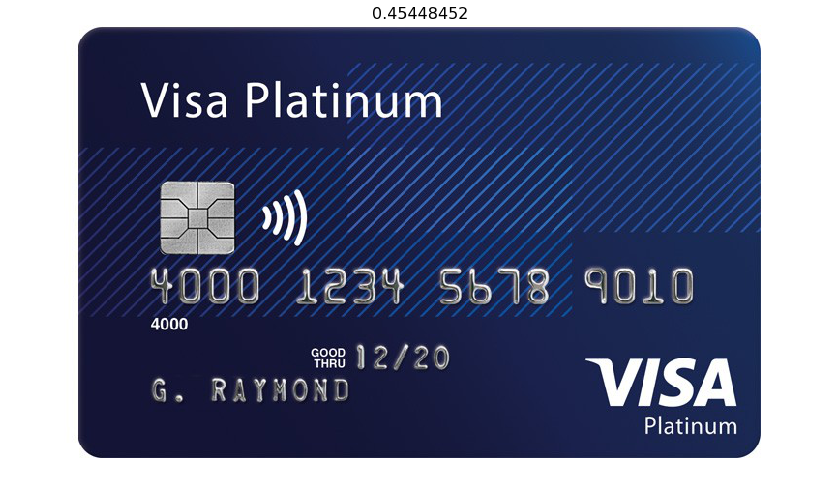

In [101]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect Mastercard")

Most uncertain predictions


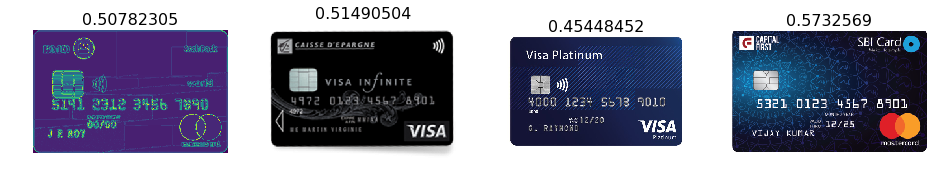

In [102]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")